In [1]:
import hail as hl
hl.init()


KeyboardInterrupt



In [3]:
import onnx
from gnomad.sample_qc.ancestry import apply_onnx_classification_model, assign_population_pcs
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import show
from bokeh.layouts import gridplot

get ancestry assignments

In [16]:
gnomad_v4_onnx_rf = "../RF_gnomad_models/gnomad.v4.0.RF_fit.onnx"
with hl.hadoop_open(gnomad_v4_onnx_rf, "rb") as f:
    v4_onx_fit = onnx.load(f)

In [17]:
v4_num_pcs = 20
v4_min_prob = 0.75

In [5]:
v4_pcs_ht = hl.read_table("../gnomad_pca_projections/v4_pcs_ht_with_ref_added.ht")
v4_pcs_ht.show()

,
s,scores
str,array<float64>
"""CW-170-S""","[7.72e-03,3.90e-03,8.61e-03,1.13e-01,1.73e-02,-1.12e-03,-6.42e-03,-4.21e-03,6.32e-03,8.63e-03,-1.34e-03,-8.29e-06,8.26e-04,1.23e-03,4.03e-04,2.27e-04,-1.40e-03,-1.73e-03,-2.43e-03,-2.29e-03,3.69e-04,-1.28e-03,1.57e-03,-1.80e-03,-9.14e-04,4.27e-03,-2.03e-03,-1.61e-03,2.77e-03,3.50e-04]"
"""CW-179-S""","[1.10e-02,6.74e-03,-4.61e-03,-2.64e-03,-6.00e-03,2.22e-04,-8.75e-04,-9.41e-04,1.67e-03,1.93e-03,-1.58e-03,-4.67e-04,3.85e-04,-2.23e-03,1.29e-03,-4.76e-04,2.55e-03,7.22e-05,3.83e-04,1.45e-03,-3.91e-04,1.57e-04,6.59e-04,3.95e-04,4.01e-04,-9.03e-04,2.18e-03,-1.06e-03,-4.07e-03,1.56e-03]"
"""CW117-S""","[8.71e-03,2.78e-03,9.44e-03,1.27e-01,2.11e-02,3.98e-05,-8.44e-03,-5.87e-03,8.47e-03,1.04e-02,5.22e-04,7.48e-04,-1.07e-03,-5.53e-03,2.46e-03,-5.96e-04,-3.02e-03,1.05e-03,-2.22e-03,-1.55e-03,8.92e-05,-4.05e-04,2.53e-03,1.96e-04,2.98e-03,-2.67e-03,1.12e-03,-6.16e-04,-1.83e-03,-1.16e-03]"
"""CW12S""","[8.24e-03,4.36e-03,7.96e-03,1.07e-01,1.49e-02,-1.30e-03,-5.18e-03,-3.37e-03,7.88e-03,9.62e-03,-2.88e-04,9.67e-04,-3.63e-03,1.71e-03,8.67e-04,8.47e-05,-1.95e-03,-5.40e-04,7.98e-04,-2.74e-03,1.37e-03,-1.13e-03,3.69e-05,-3.01e-03,2.76e-03,1.07e-04,-9.26e-04,2.92e-04,-3.06e-03,-1.32e-04]"
"""CW140-G""","[8.01e-03,2.81e-03,5.61e-03,8.14e-03,-2.83e-03,3.52e-05,3.67e-03,5.41e-03,-1.34e-02,-1.78e-02,-1.62e-03,-8.87e-04,6.46e-03,-1.09e-04,-9.93e-03,2.76e-03,1.02e-02,-2.31e-03,7.50e-03,1.01e-04,-9.37e-04,1.57e-04,-5.67e-03,-4.02e-05,1.99e-03,-1.21e-03,5.66e-03,-1.41e-03,-8.48e-04,-2.41e-03]"
"""CW215-S""","[6.69e-03,4.95e-03,7.66e-03,9.93e-02,1.59e-02,-1.08e-03,-6.32e-03,-2.65e-03,3.27e-03,4.08e-03,-5.91e-04,1.05e-03,-1.07e-03,1.75e-03,2.57e-03,-6.29e-04,-2.71e-03,7.47e-04,2.77e-04,1.16e-03,1.59e-03,-5.71e-04,1.66e-03,9.34e-04,-2.96e-03,-1.01e-04,4.87e-04,1.16e-04,-3.86e-04,-2.66e-03]"
"""CW226-S""","[1.07e-02,6.51e-03,-4.77e-03,-3.31e-04,-3.61e-03,1.47e-04,9.90e-04,4.98e-04,-1.15e-03,-1.97e-03,1.27e-03,-3.79e-04,4.17e-04,3.43e-04,-1.15e-03,5.82e-04,1.64e-03,2.49e-05,9.70e-04,-3.97e-04,-7.64e-04,-5.99e-05,-7.24e-04,1.31e-03,-8.42e-04,-1.31e-03,2.74e-03,-1.19e-04,-3.34e-03,-7.59e-04]"
"""CW232-S""","[8.51e-03,5.81e-03,1.22e-03,3.72e-03,-2.52e-03,4.02e-04,5.24e-04,4.01e-03,-8.73e-03,-1.22e-02,-2.46e-03,1.15e-05,5.52e-03,-8.52e-04,-6.43e-03,1.80e-03,4.86e-03,-1.84e-03,6.10e-03,-9.69e-04,-5.46e-04,-6.07e-04,-3.04e-03,-1.59e-03,2.34e-03,1.34e-03,4.55e-03,-1.63e-03,-8.24e-03,2.17e-03]"


In [7]:
v4_results_ht, v3_model = assign_population_pcs(
    v4_pcs_ht,
    pc_cols=v4_pcs_ht.scores[:v4_num_pcs],
    fit=v4_onx_fit,
    min_prob=0.7,
    apply_model_func = apply_onnx_classification_model
)

INFO (gnomad.sample_qc.ancestry 369): Found the following sample count after population assignment: asj: 66, nfe: 248, oth: 14, amr: 3, sas: 1, mid: 1, afr: 1


In [8]:
v4_results_ht.show()

,,,,,,,,,,,
s,pca_scores,pop,prob_afr,prob_ami,prob_amr,prob_asj,prob_eas,prob_fin,prob_mid,prob_nfe,prob_sas
str,array<float64>,str,float64,float64,float64,float64,float64,float64,float64,float64,float64
"""CW-170-S""","[7.72e-03,3.90e-03,8.61e-03,1.13e-01,1.73e-02,-1.12e-03,-6.42e-03,-4.21e-03,6.32e-03,8.63e-03,-1.34e-03,-8.29e-06,8.26e-04,1.23e-03,4.03e-04,2.27e-04,-1.40e-03,-1.73e-03,-2.43e-03,-2.29e-03]","""asj""",1.00e-02,0.00e+00,1.00e-02,9.80e-01,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
"""CW-179-S""","[1.10e-02,6.74e-03,-4.61e-03,-2.64e-03,-6.00e-03,2.22e-04,-8.75e-04,-9.41e-04,1.67e-03,1.93e-03,-1.58e-03,-4.67e-04,3.85e-04,-2.23e-03,1.29e-03,-4.76e-04,2.55e-03,7.22e-05,3.83e-04,1.45e-03]","""nfe""",1.00e-02,0.00e+00,3.00e-02,1.00e-02,1.00e-02,2.00e-02,0.00e+00,9.10e-01,1.00e-02
"""CW117-S""","[8.71e-03,2.78e-03,9.44e-03,1.27e-01,2.11e-02,3.98e-05,-8.44e-03,-5.87e-03,8.47e-03,1.04e-02,5.22e-04,7.48e-04,-1.07e-03,-5.53e-03,2.46e-03,-5.96e-04,-3.02e-03,1.05e-03,-2.22e-03,-1.55e-03]","""asj""",0.00e+00,0.00e+00,0.00e+00,1.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00
"""CW12S""","[8.24e-03,4.36e-03,7.96e-03,1.07e-01,1.49e-02,-1.30e-03,-5.18e-03,-3.37e-03,7.88e-03,9.62e-03,-2.88e-04,9.67e-04,-3.63e-03,1.71e-03,8.67e-04,8.47e-05,-1.95e-03,-5.40e-04,7.98e-04,-2.74e-03]","""asj""",5.00e-02,0.00e+00,2.00e-02,8.50e-01,2.00e-02,0.00e+00,0.00e+00,6.00e-02,0.00e+00
"""CW140-G""","[8.01e-03,2.81e-03,5.61e-03,8.14e-03,-2.83e-03,3.52e-05,3.67e-03,5.41e-03,-1.34e-02,-1.78e-02,-1.62e-03,-8.87e-04,6.46e-03,-1.09e-04,-9.93e-03,2.76e-03,1.02e-02,-2.31e-03,7.50e-03,1.01e-04]","""nfe""",0.00e+00,0.00e+00,3.00e-02,0.00e+00,0.00e+00,0.00e+00,0.00e+00,9.70e-01,0.00e+00
"""CW215-S""","[6.69e-03,4.95e-03,7.66e-03,9.93e-02,1.59e-02,-1.08e-03,-6.32e-03,-2.65e-03,3.27e-03,4.08e-03,-5.91e-04,1.05e-03,-1.07e-03,1.75e-03,2.57e-03,-6.29e-04,-2.71e-03,7.47e-04,2.77e-04,1.16e-03]","""asj""",3.00e-02,0.00e+00,6.00e-02,7.30e-01,1.00e-02,1.00e-02,0.00e+00,1.60e-01,0.00e+00
"""CW226-S""","[1.07e-02,6.51e-03,-4.77e-03,-3.31e-04,-3.61e-03,1.47e-04,9.90e-04,4.98e-04,-1.15e-03,-1.97e-03,1.27e-03,-3.79e-04,4.17e-04,3.43e-04,-1.15e-03,5.82e-04,1.64e-03,2.49e-05,9.70e-04,-3.97e-04]","""nfe""",1.00e-02,0.00e+00,2.00e-02,2.00e-02,0.00e+00,1.00e-02,0.00e+00,9.20e-01,2.00e-02
"""CW232-S""","[8.51e-03,5.81e-03,1.22e-03,3.72e-03,-2.52e-03,4.02e-04,5.24e-04,4.01e-03,-8.73e-03,-1.22e-02,-2.46e-03,1.15e-05,5.52e-03,-8.52e-04,-6.43e-03,1.80e-03,4.86e-03,-1.84e-03,6.10e-03,-9.69e-04]","""nfe""",1.00e-02,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,9.90e-01,0.00e+00


In [9]:
samples_of_interest = {"DFCI-154P-C", "DFCI-568R-C", "DFCI-166P-C"}
samples_of_interest = hl.literal(samples_of_interest)
v4_results_ht.filter(samples_of_interest.contains(v4_results_ht["s"])).to_pandas().drop(columns="pca_scores")

2024-06-07 15:06:11.385 Hail: INFO: Coerced sorted dataset


,s,pop,prob_afr,prob_ami,prob_amr,prob_asj,prob_eas,prob_fin,prob_mid,prob_nfe,prob_sas
0,DFCI-154P-C,oth,0.04,0.0,0.04,0.22,0.01,0.02,0.03,0.59,0.05
1,DFCI-166P-C,amr,0.04,0.02,0.74,0.0,0.0,0.0,0.0,0.2,0.0
2,DFCI-568R-C,oth,0.06,0.0,0.08,0.16,0.03,0.04,0.01,0.57,0.05


In [10]:
v4_results_df = pd.read_csv("../gnomad_pca_projections/v4_pcs_ht_copy_gnomad_workflow.tsv", sep="\t", index_col=0)
v4_results_df.loc[:, "scores"] = v4_results_df.scores.apply(lambda x: [float(y) for y in x.strip("[]").split(",")])
v4_results_df.head()

,scores
s,
CW-170-S,"[-0.0010380223871799877, 0.0001377195826216701..."
CW-179-S,"[0.002238793419696749, 0.002975466848851369, -..."
CW117-S,"[-3.94738718905708e-05, -0.0009828106156535468..."
CW12S,"[-0.0005161591734873076, 0.0005947731833153549..."
CW140-G,"[-0.0007476901299114795, -0.000957266271829790..."


In [11]:
v4_results_df.loc[:, "scores"] = v4_results_df.scores.apply(lambda x: x[0:20])
len(v4_results_df.scores.iloc[0])

20

In [12]:
pc_cols = ["PC" + str(i) for i in range(1,21)]
v4_results_df = pd.DataFrame(v4_results_df.scores.to_list(), index=v4_results_df.index, columns=pc_cols)
#v4_results_df["Ancestry Assigned by Gnomad"] = v4_results_ht["pop"].collect()
v4_results_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
s,,,,,,,,,,,,,,,,,,,,
CW-170-S,-0.001038,0.000138,0.010739,0.112265,0.018732,-0.001194,-0.007350,-0.003840,0.006583,0.009050,-0.002030,-0.000325,0.000783,0.001149,0.000815,0.000265,-0.001271,-0.001679,-0.002769,-0.002365
CW-179-S,0.002239,0.002975,-0.002483,-0.003688,-0.004554,0.000150,-0.001801,-0.000568,0.001934,0.002351,-0.002275,-0.000784,0.000342,-0.002312,0.001698,-0.000438,0.002681,0.000119,0.000047,0.001374
CW117-S,-0.000039,-0.000983,0.011564,0.126369,0.022557,-0.000032,-0.009366,-0.005493,0.008727,0.010807,-0.000169,0.000431,-0.001113,-0.005610,0.002871,-0.000558,-0.002894,0.001097,-0.002559,-0.001626
CW12S,-0.000516,0.000595,0.010090,0.105611,0.016352,-0.001376,-0.006102,-0.002999,0.008146,0.010044,-0.000979,0.000651,-0.003676,0.001627,0.001280,0.000123,-0.001820,-0.000494,0.000462,-0.002822
CW140-G,-0.000748,-0.000957,0.007738,0.007100,-0.001391,-0.000036,0.002744,0.005780,-0.013102,-0.017392,-0.002307,-0.001203,0.006418,-0.000193,-0.009513,0.002797,0.010322,-0.002262,0.007159,0.000022


In [13]:
ancestry_df = pd.read_csv("../ancestry_probs.tsv", sep="\t", index_col=0)
ancestry_df.head()

,pca_scores,pop,prob_afr,prob_ami,prob_amr,prob_asj,prob_eas,prob_fin,prob_mid,prob_nfe,prob_sas
s,,,,,,,,,,,
CW-170-S,"[-0.0010380223871799877,1.3771958262167013E-4,...",asj,0.01,0.0,0.03,0.86,0.02,0.00,0.03,0.04,0.01
CW-179-S,"[0.002238793419696749,0.002975466848851369,-0....",nfe,0.14,0.0,0.22,0.03,0.04,0.04,0.00,0.52,0.01
CW117-S,"[-3.94738718905708E-5,-9.828106156535468E-4,0....",asj,0.02,0.0,0.03,0.86,0.02,0.00,0.01,0.05,0.01
CW12S,"[-5.161591734873076E-4,5.947731833153549E-4,0....",asj,0.04,0.0,0.06,0.78,0.02,0.00,0.03,0.06,0.01
CW140-G,"[-7.476901299114795E-4,-9.572662718297909E-4,0...",nfe,0.02,0.0,0.21,0.00,0.01,0.02,0.09,0.63,0.02


In [14]:
(ancestry_df.index == v4_results_df.index).all()

True

In [15]:
v4_results_df.loc[ancestry_df.index, "pop"] = ancestry_df["pop"]
v4_results_df = v4_results_df.rename(columns={"pop": "Ancestry Assigned by Gnomad"})
v4_results_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,Ancestry Assigned by Gnomad
s,,,,,,,,,,,,,,,,,,,,,
CW-170-S,-0.001038,0.000138,0.010739,0.112265,0.018732,-0.001194,-0.007350,-0.003840,0.006583,0.009050,...,-0.000325,0.000783,0.001149,0.000815,0.000265,-0.001271,-0.001679,-0.002769,-0.002365,asj
CW-179-S,0.002239,0.002975,-0.002483,-0.003688,-0.004554,0.000150,-0.001801,-0.000568,0.001934,0.002351,...,-0.000784,0.000342,-0.002312,0.001698,-0.000438,0.002681,0.000119,0.000047,0.001374,nfe
CW117-S,-0.000039,-0.000983,0.011564,0.126369,0.022557,-0.000032,-0.009366,-0.005493,0.008727,0.010807,...,0.000431,-0.001113,-0.005610,0.002871,-0.000558,-0.002894,0.001097,-0.002559,-0.001626,asj
CW12S,-0.000516,0.000595,0.010090,0.105611,0.016352,-0.001376,-0.006102,-0.002999,0.008146,0.010044,...,0.000651,-0.003676,0.001627,0.001280,0.000123,-0.001820,-0.000494,0.000462,-0.002822,asj
CW140-G,-0.000748,-0.000957,0.007738,0.007100,-0.001391,-0.000036,0.002744,0.005780,-0.013102,-0.017392,...,-0.001203,0.006418,-0.000193,-0.009513,0.002797,0.010322,-0.002262,0.007159,0.000022,nfe


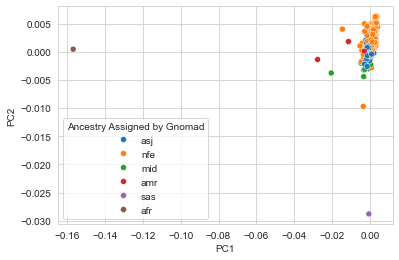

In [16]:
sns.scatterplot(v4_results_df, x="PC1", y="PC2", hue="Ancestry Assigned by Gnomad")
plt.show()

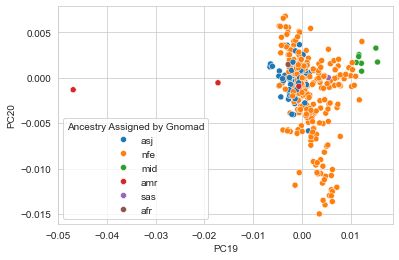

In [17]:
for i in range(1, 20):
    plt.clf()
    pc1 = "PC" + str(i)
    pc2 = "PC" + str(i + 1)
    filename = "../gnomad_pcs/" + pc1 + "_" + pc2 + ".png"
    sns.scatterplot(v4_results_df, x=pc1, y=pc2, hue="Ancestry Assigned by Gnomad")
    plt.xlabel(pc1)
    plt.ylabel(pc2)
    plt.savefig(filename)

In [18]:
reducer = umap.UMAP()

embedding = reducer.fit_transform(v4_results_df.iloc[:, 0:11])
embedding.shape

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(334, 2)

In [19]:
embedding_df = pd.DataFrame(embedding, index=v4_results_df.index)
embedding_df.loc[:, "Ancestry Assigned by Gnomad"] = v4_results_df["Ancestry Assigned by Gnomad"]
embedding_df.head()

,0,1,Ancestry Assigned by Gnomad
s,,,
CW-170-S,-0.633458,8.851862,asj
CW-179-S,13.758637,10.670715,nfe
CW117-S,-2.554828,9.776060,asj
CW12S,0.372812,9.139223,asj
CW140-G,11.534995,3.011363,nfe


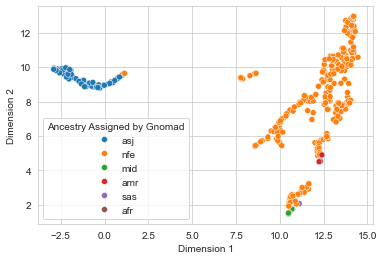

In [20]:
plt.clf()
sns.scatterplot(embedding_df, x=0, y=1, hue="Ancestry Assigned by Gnomad")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig("umap.png")
plt.show()

In [19]:
import plotly.express as px

fig = px.scatter(embedding_df, x=0, y=1,
                 hover_name=embedding_df.index, labels={0: "Dimension 1", 1: "Dimension 2"})
fig.show()

In [27]:
embedding_df["Ancestry Assigned by Gnomad"].to_csv("../results/gnomad_ancestries.tsv",
                                                   sep="\t")